In [106]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import modelos as md
from importlib import reload
reload(md)

<module 'modelos' from 'c:\\Users\\Bergson\\Desktop\\UFPB\\Quinto Período\\Machine Learning\\projeto 1\\repositorio\\Reconhecimento-de-digitos-ML-2023.2\\modelos.py'>

In [107]:
dataframe_treino = pd.read_csv('train_redu.csv', sep=';')
dataframe_teste = pd.read_csv('test_reduzido.csv', sep=';')

In [108]:
dataframe_treino['label']

0       0
1       0
2       0
3       0
4       0
       ..
2181    5
2182    5
2183    5
2184    5
2185    5
Name: label, Length: 2186, dtype: int64

# Tratamento dos dados

In [113]:
# Funçao para transformar os dados em uma normal 0,1
def padronizar_normal(matriz_X):
    for i in range(np.shape(matriz_X)[1]):
        matriz_X[:,i] = (matriz_X[:,i] - np.mean(matriz_X[:,i]))/np.std(matriz_X[:,i]) # X menos media/desvio padrao

    return matriz_X

# Obtendo os valores de treino e teste
X = dataframe_treino[['intensidade', 'simetria']].values.copy()
X_teste = dataframe_teste[['intensidade', 'simetria']].values
Y = dataframe_treino['label'].values.copy()
y_teste = dataframe_teste['label'].values

# Transformando os dados e alterando os valores de label para 1 e -1
X = padronizar_normal(X)
X_teste = padronizar_normal(X_teste)

# Adicionando uma coluna de 1s
X = np.c_[np.ones(len(X)), X]
X_teste = np.c_[np.ones(len(X_teste)), X_teste]

# Usando a Regressão Logística

In [110]:
def classificador_de_todos_os_digitos_treinamento(df_treino, lista_digitos):
    X = np.array(df_treino[['intensidade', 'simetria']].values.copy())
    X = padronizar_normal(X)
    X = np.c_[np.ones(len(X)), X]
    Y = np.array(df_treino['label'].values.copy())
    print('Y', Y)
    w_matrix = []
    y_pred_treino_matrix = []
    retas_formadas_treino = []
    x = np.linspace(-2, 2, 100)
    modelo = md.RegressaoLogistica()
    for i in range(len(lista_digitos) - 1):
        
        Y[Y != lista_digitos[i]] = -1
        Y[Y == lista_digitos[i]] = 1
        print('Y', Y)
        w, acuracia, y_pred_treino = modelo.fit(X.T, Y) # Passo o X.transpose() para que a multiplicação de matrizes seja possível
        print('y pred treino da funcao', y_pred_treino)
        w_matrix.append(w)
        y_pred_treino_matrix.append(y_pred_treino)
        retas_formadas_treino.append((-w[0] - w[1]*x) / w[2])
        # obtenha o indice dos valores de y_pred_treino que são 1 e retirando os elementos correspondentes em X e Y

        indices = np.where(y_pred_treino == 1)[0]
        X = np.delete(X, indices, axis=0)
        Y = np.delete(Y, indices, axis=0)





        #df_treino = df_treino[df_treino['label'] != lista_digitos[i]].copy()
        #print('df_treino', df_treino)

        #Y = df_treino['label'].values.copy()
    
    return w_matrix, y_pred_treino_matrix, retas_formadas_treino
        


'''#Criando a matriz de confusão
matriz_de_confusao_treino = confusion_matrix(Y, y_pred_treino)
print(matriz_de_confusao_treino)

#Printando o relatório de classificação
print(classification_report(Y, y_pred_treino, target_names=['1', '5']))

# Voltando os valores de y_pred_treino para 1 e 5
y_pred_treino[y_pred_treino == -1] = 5'''


"#Criando a matriz de confusão\nmatriz_de_confusao_treino = confusion_matrix(Y, y_pred_treino)\nprint(matriz_de_confusao_treino)\n\n#Printando o relatório de classificação\nprint(classification_report(Y, y_pred_treino, target_names=['1', '5']))\n\n# Voltando os valores de y_pred_treino para 1 e 5\ny_pred_treino[y_pred_treino == -1] = 5"

Y [0 0 0 ... 5 5 5]
Y [ 1  1  1 ... -1 -1 -1]
y pred treino da funcao [ 1. -1.  1. ... -1. -1. -1.]
Y [ 1  1  1 ... -1 -1 -1]
y pred treino da funcao [-1. -1. -1. ... -1. -1. -1.]
Y [-1 -1 -1 ... -1 -1 -1]
y pred treino da funcao [-1. -1. -1. ... -1. -1. -1.]
[ 1. -1.  1. ... -1. -1. -1.]
              precision    recall  f1-score   support

           1       0.67      0.80      0.73      1578
       nao_1       0.00      0.00      0.00       608

    accuracy                           0.58      2186
   macro avg       0.34      0.40      0.37      2186
weighted avg       0.49      0.58      0.53      2186



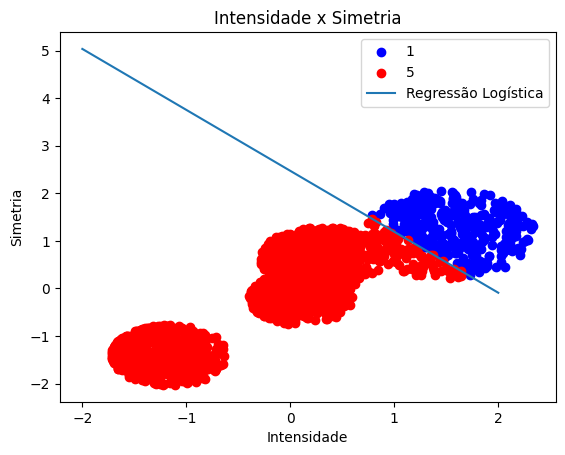

In [114]:
digitos = [0,1,4,5]
Y[Y != 1] = -1
x = np.linspace(-2, 2, 100)
w_matrix, y_pred_treino_matrix, retas_formadas_treino = classificador_de_todos_os_digitos_treinamento(dataframe_treino, digitos)
print(y_pred_treino_matrix[0])
print(classification_report(Y, y_pred_treino_matrix[0], target_names=['1','nao_1']))
plt.scatter(X[y_pred_treino_matrix[0] == 1, 1], X[y_pred_treino_matrix[0] == 1, 2], color='blue', marker='o', label='1')
plt.scatter(X[y_pred_treino_matrix[0] == -1, 1], X[y_pred_treino_matrix[0] == -1, 2], color='red', marker='o', label='5')
plt.plot(x, retas_formadas_treino[0], label='Regressão Logística')
plt.xlabel('Intensidade')
plt.ylabel('Simetria')
plt.title('Intensidade x Simetria')
plt.legend()
plt.show()

In [112]:
dataframe_treino['label']

0       0
1       0
2       0
3       0
4       0
       ..
2181    5
2182    5
2183    5
2184    5
2185    5
Name: label, Length: 2186, dtype: int64